In [2]:
!pip install adjustText

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import ndcg_score
import dask.dataframe as dd
from dask.dataframe import from_pandas
from itertools import combinations
from collections import Counter
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from adjustText import adjust_text
from sklearn import preprocessing

In [4]:
df_node= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Erdos_tgbn_2024/data/tgbn-genre_node_labels.csv")
df_node['ts']= pd.to_datetime(df_node['ts'], unit= 's') # timestamp to datetime
df_node['ts'] = pd.to_datetime(df_node['ts'].dt.strftime('%Y-%m-%d')) # dont need time because the timestamp is reset to the beginning of day in order to calculate the frequency vector label
df_node['user_id']=df_node['user_id'].str.slice(5).astype('Int64') #convert user_id to integers
df_node # remember weight is the frequency vector entries, not the actual weight

,ts,user_id,genre,weight
0,2005-02-15,54,chillout,0.015835
1,2005-02-15,54,female vocalist,0.015330
2,2005-02-15,54,downtempo,0.008128
3,2005-02-15,54,electronic,0.072162
4,2005-02-15,54,reggae,0.021465
...,...,...,...,...
2741930,2009-06-12,651,katy perry,0.004864
2741931,2009-06-12,724,bebop,0.041841
2741932,2009-06-12,724,jazz,0.958159
2741933,2009-06-12,802,Britney Spears,0.359504


In [5]:
# Train Validation Test Split
np.quantile(df_node['ts'].unique(), [0.7,0.85]) #70-15-15 split of the timestamps

array(['2008-02-24T14:23:59.999999993', '2008-10-18T07:11:59.999999996'],
      dtype='datetime64[ns]')

In [6]:
train= df_node.loc[df_node['ts']<datetime(2008,2,25)]
val= df_node.loc[(datetime(2008,2,25)<=df_node['ts']) & (df_node['ts']<=datetime(2008,10,18))]
test= df_node.loc[datetime(2008,10,18)<df_node['ts']]

In [7]:
train

,ts,user_id,genre,weight
0,2005-02-15,54,chillout,0.015835
1,2005-02-15,54,female vocalist,0.015330
2,2005-02-15,54,downtempo,0.008128
3,2005-02-15,54,electronic,0.072162
4,2005-02-15,54,reggae,0.021465
...,...,...,...,...
1638965,2008-02-24,995,pop,0.017661
1638966,2008-02-24,995,acoustic,0.146607
1638967,2008-02-24,995,soul,0.088105
1638968,2008-02-24,995,jazz,0.050220


In [8]:
train_labels= train.groupby(['user_id','genre']).agg({'weight': 'mean'}).reset_index()
train_labels.rename(columns={'weight':'weight_mean'}, inplace=True)
train_labels # we will use this to make prediction

,user_id,genre,weight_mean
0,1,80s,0.292930
1,1,Coldplay,0.055873
2,1,Drum and bass,0.094912
3,1,Grunge,0.136364
4,1,Lo-Fi,0.069268
...,...,...,...
86660,1000,soul,0.200897
86661,1000,swing,0.005391
86662,1000,trip hop,0.019362
86663,1000,turntablism,0.011806


Note that not all users have weight for all 513 genres. We need to fill the missing ones with 0.0.

In [9]:
train_labels= train_labels.groupby(["user_id",'genre'])[["weight_mean"]].first().unstack(fill_value=0.0).stack().reset_index()
train_labels # note 747*512= 402944

,user_id,genre,weight_mean
0,1,00s,0.0
1,1,1970s,0.0
2,1,1980s,0.0
3,1,1990s,0.0
4,1,2000s,0.0
...,...,...,...
402939,1000,westlife,0.0
402940,1000,whitney houston,0.0
402941,1000,world,0.0
402942,1000,wu-tang,0.0


In [10]:
train_vec=train_labels.groupby(['user_id'])['weight_mean'].apply(list).reset_index() #making the vector of genre weights
train_vec

,user_id,weight_mean
0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,"[0.0, 0.0018839934832565334, 0.017576028652103..."
2,3,"[0.0143502804629589, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,"[0.0, 0.0, 0.0, 0.0018357798531965, 0.05486343..."
4,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
782,995,"[0.012532068759198201, 0.036233984761927664, 0..."
783,996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
784,997,"[0.0, 0.0, 0.003002684368363, 0.01338569245913..."
785,998,"[0.0, 0.0, 0.0, 0.0, 0.0117441851144799, 0.0, ..."


In [11]:
train_vec['user_id'].nunique()

787

In [12]:
M=np.array([np.array(xi) for xi in train_vec['weight_mean'].values])

In [15]:
M_norm= preprocessing.normalize(M)

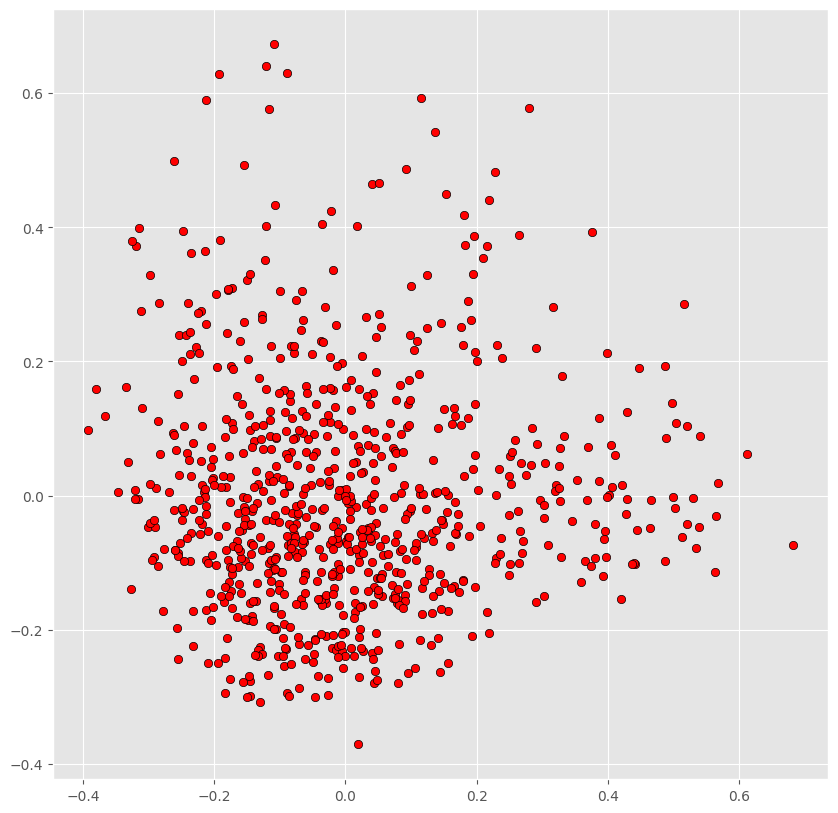

In [26]:
#plt.rcParams.update({'font.size': .5})
plt.style.use('ggplot')
two_d = PCA().fit_transform(M_norm)[:,:2]
plt.figure(figsize=(10,10))
plt.scatter(two_d[:,0], two_d[:,1], edgecolors='k', c ='r')
#texts = [plt.text(two_d[i][0], two_d[i][1], i, ha='center', va='center') for i in range(787)]
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='blue'))